### Script by: Themba Gqaza


This is the second script that I've produced.  The first script extracts $\&$ stores the subcubes of possible sources from the data cube.

#### Second script:


* Loads up the subcube (produced by the first script) and creates data products: moment maps, pv slices and global profiles.


* Calculates: Flux centroid, distance, integrated flux $\&$ HI mass.


* Fits a busy function to the spectrum of the source then calculates line widths: $w_{_{20}}$ $\&$ $w_{_{50}}$, $\textit{Westmeier et al. 2014}$.


* Tabulates the measurements of each source.



## Script:

#### Import all the modules required and load a data cube.



In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from numpy import median,mean, std, histogram, arange, exp, zeros, ones, array, unique
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter, uniform_filter1d
from scipy.ndimage.measurements import label
import numpy as np
from astropy import wcs
from scipy.special import erf
from math import sqrt, log, sin, cos, asin, atan2, degrees, radians, pi
from astropy.table import Table, Column
import aplpy



get_ipython().magic(u'matplotlib inline')



In [2]:


#Load data
dir = '/home/themba/Documents/MSc/Thesis/Data/ATC/ATC2/Noisy_data/D1/'
#1 Open the data cube in python
hdr =fits.getheader('/home/themba/Documents/MSc/Thesis/Data/ATC/ATC2/Noisy_data/D1.fits')
nani='/home/themba/Documents/MSc/Thesis/Data/ATC/ATC2/Noisy_data/D1/P_103:92:43.fits'
cubeFile = fits.open(nani)
cube   = cubeFile[0].data
header = cubeFile[0].header
cubeFile.close()






#### Get noise properties of the data cube.



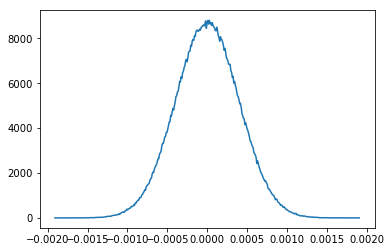

Noise = 0.39783 mJY/BM


In [32]:
#2 Estimate the noise level in the data
#2.1 plotting the noise distribution
def histo(cube):
    binEdges      = arange(cube.min(),abs(cube.min()),(cube.max()-cube.min())/1000)
    bins          = (binEdges[1:]+binEdges[:-1])/2
    hist,binEdges = histogram(cube, bins=binEdges)

    rmsSTD = std(cube)
    plt.plot(bins,hist)
    plt.show()
    print 'Noise = '+str(round(1e3*rmsSTD,5))+' m'+header['BUNIT']
histo(cube)

In [4]:
#2.4 Fit of negative part of the noise distribution
def GaussianNoise(F,N0,s0):
  return N0*exp(-F**2/2/s0**2)

def rmsFit(Cube):
  ## Make histogram of voxel values in the cube
  binEdges      = arange(Cube.min(),abs(cube.min())/1000,abs(cube.min())/1000)
  bins          = (binEdges[1:]+binEdges[:-1])/2
  hist,binEdges = histogram(Cube, bins=binEdges)
  ## Fit histogram
  p0=[hist.max(),-bins[hist<hist.max()/2].max()*2/2.355]
  return curve_fit(GaussianNoise,hist,bins,p0=p0)[0][1]

print 'Noise = '+str(1e3*rmsFit(cube))+' m'+header['BUNIT']

Noise = 0.377634562445 mJY/BM


/home/themba/anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


#### Use smooth and clip method  to create mask $\textit{(Serra et al. 2012)}$.  Show a channel map of the masked cube

smoothing with kernel of size: [ 0 , 0 , 0 ]
smoothing with kernel of size: [ 0 , 0 , 3 ]
smoothing with kernel of size: [ 0 , 0 , 7 ]
smoothing with kernel of size: [ 0 , 0 , 15 ]
smoothing with kernel of size: [ 3 , 3 , 0 ]
smoothing with kernel of size: [ 3 , 3 , 3 ]
smoothing with kernel of size: [ 3 , 3 , 7 ]
smoothing with kernel of size: [ 3 , 3 , 15 ]
smoothing with kernel of size: [ 6 , 6 , 0 ]
smoothing with kernel of size: [ 6 , 6 , 3 ]
smoothing with kernel of size: [ 6 , 6 , 7 ]
smoothing with kernel of size: [ 6 , 6 , 15 ]


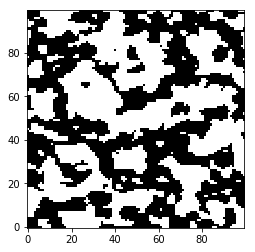

In [5]:
#3 Detection of voxels that contain signal
#3.1 define kernel sizes for spatial & spectral smoothing & mask (initially empty)
kernelsSpat = [0,3,6]
kernelsSpec  = [0,3,7,15]
mask = zeros(cube.shape)
Mask = zeros(cube.shape)

#3.2 smooth and clip
for kSpat in kernelsSpat:
  for kSpec in kernelsSpec:
    print 'smoothing with kernel of size: [',kSpat,',',kSpat,',',kSpec,']'
    ### spatial smoothing
    smoothedCube = gaussian_filter(cube,[0,kSpat/2.355,kSpat/2.355],mode='constant')
    ### spectral smoothing
    if kSpec!=0:
      smoothedCube = uniform_filter1d(smoothedCube,kSpec,axis=0,mode='constant')
    ### estimate noise for the smoothed cube
    rms = rmsFit(smoothedCube)
    ### add pixels above 3 sigma limit to mask
    mask[smoothedCube>=1*rms] = 1
Mask[smoothedCube>=0] = 1 
## show one channel of the resulting mask (channel 30)
plt.imshow(mask[50],cmap='gray',interpolation='nearest')
plt.gca().invert_yaxis()
plt.show()



#### Group identified voxels into sources

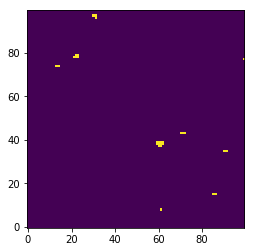

In [6]:
#Show a channel map
maskIDs = label(mask)[0]
plt.imshow(maskIDs[50])
plt.gca().invert_yaxis()
plt.show()

#### Remove smaller detections and relabel sources.

2


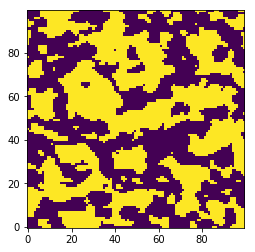

In [7]:
counter = 1
for ID in unique(maskIDs)[1:]:
  # remove all "islands" with #voxels<700
  if (maskIDs[maskIDs==ID].sum())/ID<1700:
    maskIDs[maskIDs==ID] = 0
  else:
    # assign a new ID to remaining sources
    maskIDs[maskIDs==ID] = counter
    counter+=1
#fits.writeto(dir+'themba_msk.fits',maskIDs,clobber=True) #masked
print counter
plt.imshow(maskIDs[50],origin='bottom')
plt.show()




## Calculate flux centroid of the source
 
 
 \begin{eqnarray}
 \textbf{p} = \frac{\sum_i \textbf{p}_i S(\textbf{p}_i)}{\sum_i  S(\textbf{p}_i)}
 \end{eqnarray}
 
   Where: $\textbf{p}$ is a flux centroid, $\textbf{p}_i$ is a position vector of the $i^{th}$ voxel $\&$ $S(\textbf{p}_i)$ is the flux of the $i^{th}$ voxel.

In [8]:
#Check the number of sources classified as islands (possible galaxies).
labeled_array, num_features = label(maskIDs)
nf=num_features

data = cube     #cube data
mask = maskIDs  #masked cube
nz, ny, nx = data.shape  # read cube dimensions
Centroid = []
Sum_flux = []
Int_flux1 = []
for i in range(1,nf+1):
    centroid = [0.0, 0.0, 0.0]
    sum_flux = 0.0

    for x in range(nx):
        for y in range(ny):
            for z in range(nz):
                if mask[z][y][x] == i:
                    flux = data[z][y][x]
                    centroid[0] += flux * float(x)
                    centroid[1] += flux * float(y)
                    centroid[2] += flux * float(z)
                    sum_flux += flux

    centroid[0] /= sum_flux
    centroid[1] /= sum_flux
    centroid[2] /= sum_flux
    Centroid.append(centroid)
    Sum_flux.append(sum_flux)
    print "for source #"+str(i)+", Flux Centroid : " + str(centroid[0]) + ", " + str(centroid[1]) + ", " + str(centroid[2])+". Flux sum ="+str(sum_flux)  

for source #1, Flux Centroid : 49.3526461366, 49.2591334796, 46.2155052089. Flux sum =91.9917055746


#### Convert the centroid position to WCS coordinates

In [9]:

RA,Dec,Vel = [],[],[]
for i in range(nf):
    wcshead = wcs.WCS(header)
    coordinates = wcshead.wcs_pix2world(Centroid[i][0], Centroid[i][1], Centroid[i][2], 0)
    ra = coordinates[0]
    dec = coordinates[1]
    vel = coordinates[2]
    
    RA.append(ra)
    Dec.append(dec)
    Vel.append(vel)

    print "For source #"+str(i+1)+", RA  = " + str(ra) + " deg, Dec = " + str(dec) + " deg, cz = " + str(vel) + " km/s"

For source #1, RA  = 182.359988038 deg, Dec = -31.5041478309 deg, cz = 5519.42813806 km/s


a floating-point value was expected. [astropy.wcs.wcs]


### Convert from J2000 to Galactic coordinates

 \begin{eqnarray}
 \tan (\alpha_0^{\prime} - \alpha^{\prime}) = \frac{\cos(\beta) \sin(\alpha - \alpha_0)}{\sin{\beta}\cos{\beta_0} -  \cos(\beta) \sin{\beta_0} \cos(\alpha - \alpha_0)} \\\\
  \sin{\beta^{\prime} = \sin{\beta}\cos{\beta_0} +  \cos(\beta) \sin{\beta_0} \cos(\alpha - \alpha_0)}
  \end{eqnarray}

In [10]:
Glat,Glon = [], []
for i in range(nf):
    ra0 = radians(192.8595)
    dec0 = radians(27.1284)
    gl0 = radians(122.9320)
    glat = asin(sin(radians(Dec[i])) * sin(dec0) + cos(radians(Dec[i])) * cos(dec0) * cos(radians(RA[i]) - ra0))
    glon = gl0 - atan2(cos(radians(Dec[i])) * sin(radians(RA[i]) - ra0), sin(radians(Dec[i])) * cos(dec0) - cos(radians(Dec[i])) * sin(dec0) * cos(radians(RA[i]) - ra0))
    Glat.append(degrees(glat))
    Glon.append(degrees(glon))
    print "for source #"+str(i+1)+": l = " + str(degrees(glon)) + " deg, b = " + str(degrees(glat)) + " deg"

for source #1: l = 292.541693278 deg, b = 30.5187027922 deg


### Convert velocities from barycentric to LSR and GSR 


\begin{align}
V_{lsr} = V_{bar} + 9 \cos(l) \cos(b) + 12 \sin(l)\cos(b) + 7\sin(b)\\\\
V_{gsr} = V_{lsr} 220 \sin(l)\cos(b) \hspace{5.7cm}
\end{align}


In [11]:
# Determine LSR and GSR velocity
Vlsr,Vgsr = [], [] 
for i in range(nf):
    vlsr = Vel[i] + 9.0 * cos(Glon[i]) * cos(Glat[i]) + 12.0 * sin(Glon[i]) * cos(Glat[i]) +  7.0 * sin(Glat[i])
    vgsr = vlsr + 220.0 * sin(Glon[i]) * cos(Glat[i])
    Vlsr.append(vlsr)
    Vgsr.append(vgsr)
    print "for source #"+str(i+1)+": vlsr = " + str(vlsr) + " km/s, vgsr = " + str(vgsr) + " km/s"

for source #1: vlsr = 5505.9983477 km/s, vgsr = 5455.9158245 km/s


### Measure Integrated Flux
\begin{align}
S_{int} = \frac{S_{tot}}{\Omega_{PSF}}\hspace{2cm} \Omega_{PSF} = \frac{\pi \hspace{0.5mm} \theta_a \theta_b}{4 \ln (2)}
\end{align}

In [12]:

# Determine integrated flux
BMAJ,BMIN =  6.4913E-03 ,4.6136E-03
dv = abs(wcshead.wcs_pix2world(0, 0, int(centroid[2] + 1), 0)[2] - wcshead.wcs_pix2world(0, 0, int(centroid[2]), 0)[2]) # channel width in km/s
cdelt = abs(header.get("cdelt1"))  # pixel size in rad
bmaj = BMAJ / cdelt  # beam major axis in pixels
bmin = BMIN / cdelt  # beam minor axis in pixels

Int_flux = []
for i in range(nf):
    int_flux = dv * Sum_flux[i] * 4.0 * log(2.0) / (pi * bmaj * bmin)
    Int_flux.append(int_flux)
    print "for source #"+str(i+1)+": Fint = " + str(int_flux) + " Jy km/s"
print '--------------------------------------------------------------------------------------'

for source #1: Fint = 62.0268556563 Jy km/s
--------------------------------------------------------------------------------------


###  Determine HI mass
 
Turn integrated flux into HI mass using Hubble distance

\begin{eqnarray}
\frac{M_{HI}}{M_{\odot}} =\left( 2.36 \times 10^5 \right) \left(\frac{S_{int}}{Jy \hspace{1mm} km/s}\right) \left(\frac{d}{Mpc} \right)^2
\end{eqnarray}

In [13]:
# TASK 6
Distance, HI_Mass = [],[]

for i in range(nf):
    distance = Vel[i] / 70.0  # Hubble distance, assuming H0 = 70 km/s/Mpc
    hi_mass = 2.36e+5 * Int_flux[i] * distance * distance
    HI_mass = log(hi_mass) / log(10.0)
    Distance.append(distance)
    HI_Mass.append(HI_mass)
    print "for source #"+str(i+1)+": log(MHI/Msun) = " + str(HI_mass) + " at d = " + str(distance) + " Mpc"
    
print '--------------------------------------------------------------------------------------'


for source #1: log(MHI/Msun) = 10.9590838554 at d = 78.8489734009 Mpc
--------------------------------------------------------------------------------------


### Create Moment zero Map

\begin{eqnarray}
M_0(x,y) =\delta v \sum S(x,y,z)
\end{eqnarray}

































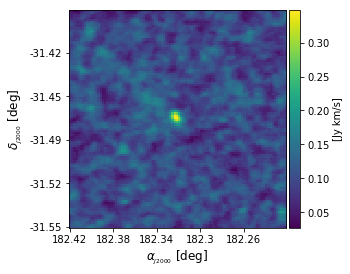

In [14]:
# TASK 7
# Calculate moment 0 map
moment0 = [[0 for x in range(nx)] for y in range(ny)]

for x in range(nx):
    for y in range(ny):
        moment0[y][x] = 0.0
        for z in range(nz):
            if mask[z][y][x] ==1 and data[z][y][x] > 0.0: moment0[y][x] += data[z][y][x]
            # NOTE: We don't multiply with dv here, so moment 0 will be in Jy * channel
mom0=np.array(moment0)*dv
mom01=np.array(moment0)
#fits.writeto("test_mom0.fits",mom0, clobber=True)
fig = plt.figure()
ax = fig.add_subplot(111) # Or we could call plt.gca() later...
im = ax.imshow(mom0)
cy=ax.get_yticks()
from astropy import units as U
#coord = wcshead.wcs_pix2world(cy[0], cy[1], 0, 0)
C1,C2 = [],[]
q=cy.shape
for i in range(1,q[0]):
    coord = wcshead.wcs_pix2world(cy[i], cy[i], 0, 0)
    C1.append(round(coord[0],2)) # RA [degrees]
    C2.append(round(coord[1],2)) #Dec [degrees]
    
# Write functions that will convert RA [deg] >> RA [hm] & Dec [deg] >> Dec [dm]
# Note you can change the ticks on the plots {from degrees to h:m & d:m} by replacing C1 & C2 by c1 & c2 respectively
def HMS(f):
    H = f/15.
    h = int(H)
    m = round((H-h)*60,1)
    #print 'RA [h:m]= 0'+str(h)+':'+str(m)
    return '0'+str(h)+':'+str(m)
    
def DMS(f):
    d = int(f)
    m = round((f - d)*60.,1)
    return str(d)+':'+str(m)

c1,c2=[],[]
for index in C1:
    c1.append(HMS(index))

for index in C2:
    c2.append(DMS(index))
#-------------------this block ends-----------------#    
    
#ax.set_xticks(cy,C1)    
cbar = fig.colorbar(im,pad=0.009)
cbar.set_label('[Jy km/s]')
ax.set_yticklabels(list(C2))
ax.set_xticklabels(list(C1))
ax.set_xlabel(r"$\alpha_{_{J2000}}$ $[\deg]$",fontsize='large')
ax.set_ylabel(r"$\delta_{_{J2000}}$ $[\deg]$",fontsize='large')
ax.axes.invert_yaxis()




### Create Moment 1 Map

\begin{eqnarray}
M_1(x,y) = \frac{\sum_z v(z) S(x,y,z)}{\sum_z S(x,y,z)}
\end{eqnarray}

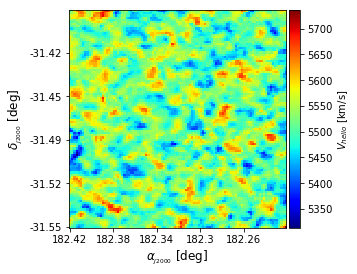

In [15]:
# TASK 8
# Calculate moment 1 map
velocity = [0 for z in range(nz)]
for z in range(nz):
    tmp = wcshead.wcs_pix2world(0, 0, z, 0)
    velocity[z] = tmp[2] 

moment1 = [[0 for x in range(nx)] for y in range(ny)]
for x in range(nx):
    for y in range(ny):
        moment1[y][x] = 0.0
        for z in range(nz):
            if mask[z][y][x] >= 1. and data[z][y][x] > 0.0: moment1[y][x] += velocity[z] * data[z][y][x]
        if moment0[y][x] > 0.0: moment1[y][x] /= moment0[y][x]
        else: moment1[y][x] = np.nan

#plt.imshow(moment1, origin="lower", cmap="jet", interpolation="nearest")
fig = plt.figure()
ax = fig.add_subplot(111) # Or we could call plt.gca() later...
im = ax.imshow(moment1, origin="lower", cmap="jet", interpolation="nearest")
cbar = fig.colorbar(im,pad=0.009)
cbar.set_label(r'$V_{helio}$ [km/s]')
ax.set_yticklabels(list(C2))
ax.set_xticklabels(list(C1))
ax.set_xlabel(r"$\alpha_{_{J2000}}$ $[\deg]$",fontsize='large')
ax.set_ylabel(r"$\delta_{_{J2000}}$ $[\deg]$",fontsize='large')

### Extract Integrated Spectrum

\begin{align}
S_{int}(z) = \frac{1}{\Omega_{PSF}} \sum_x \sum_y S(x,y,z) 
\end{align}



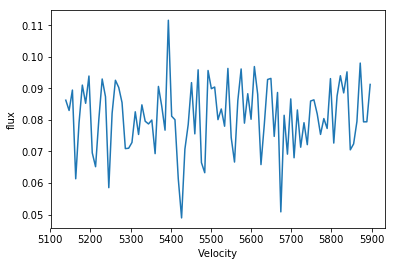

In [18]:
Spectrum=[]
for i in range(1,nf+1):
    spectrum = [0 for z in range(nz)]
    for z in range(nz):
        spectrum[z] = 0.0
        for y in range(ny):
            for x in range(nx):
                if mask[z][y][x] == 1: spectrum[z] += data[z][y][x] * 4.0 * log(2.0) / (pi * bmaj * bmin)
    Spectrum.append(spectrum)
    cwadi = open('SPEC_'+str(i)+'.txt','w')
    n = len(spectrum)
    for i in range(n): 
        cwadi.write(str(int(round(velocity[i])))+'    '+str(spectrum[i])+'\n')
    cwadi.close()
    plt.plot(velocity,spectrum)
    plt.xlabel('Velocity')
    plt.ylabel('flux')
    plt.show()
    

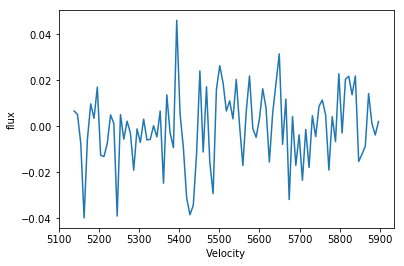

In [17]:
Spectrum1 = []
for i in range(1,nf+1):
    spectrum1 = [0 for z in range(nz)]
    for z in range(nz):
        spectrum1[z] = 0.0
        for y in range(ny):
            for x in range(nx):
                if data[z][y][x] >=-10*rmsSTD: spectrum1[z] += data[z][y][x] * 4.0 * log(2.0) / (pi * bmaj * bmin)
                    
    Spectrum1.append(spectrum1)
    cwadi = open('SPEC_Raw_'+str(i)+'.txt','w')
    n = len(spectrum1)
    for i in range(n): 
        cwadi.write(str(int(round(velocity[i])))+'    '+str(spectrum1[i])+'\n')
    cwadi.close()
    plt.plot(velocity,spectrum1)
    plt.xlabel('Velocity')
    plt.ylabel('flux')
    plt.show()

### Fit Busy Function to integrated spectrum


\begin{align}
B(z) = \left(\frac{a}{4} \right) \left[ erf \left(b_1 (w + z - z_e) \right) + 1  \right] \times
\left[ erf \left(b_2 (w - z + z_e) \right) + 1  \right] \times \left[ c \left| z-z_p\right|^n +1  \right]
\end{align}


In [110]:
# TASK 10
# Define Busy Function
def BF(x, a, b1, b2, c, w, xe, xp):
    return (a/4.0) * (erf(b1 * (w + x - xe)) + 1) * (erf(b2 * (w - x + xe)) + 1) * (c * np.absolute(x - xp) * np.absolute(x - xp) + 1)

Popt,Pcov = [],[]
# Fit Busy Function to spectrum
for i in range(nf):
    u =Vel[i] #mean(velocity)
    #popt, pcov =0.,0.
    popt, pcov = curve_fit(BF, velocity, Spectrum[i], [0.1, 0.1, 0.1, 1.0e-4, 30.0, u, u])
    print "Busy Function fit: " + str(popt[0]) + ", " + str(popt[1]) + ", " + str(popt[2]) + ", " + str(popt[3]) + ", " + str(popt[4]) + ", " + str(popt[5]) + ", " + str(popt[6])

    # -----------------------------------------------
    Popt.append(popt)
    Pcov.append(pcov)
    # TASK 11
    # Plot spectrum + BF fit
    fig = plt.figure(figsize=(12,10))
    plt.plot(velocity, Spectrum[i], drawstyle="steps-mid", color="black",label='Spectrum')
    plt.axhline(0.0, color="grey", linestyle="dashed")
    plt.xlabel("Radial velocity (km/s)",fontsize=24)
    plt.ylabel("Flux density (Jy)",fontsize=24)
    plt.plot(velocity, BF(velocity, popt[0] ,popt[1], popt[2], popt[3], popt[4], popt[5], popt[6]), color="red",label='BusyF Fit')
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='best',fontsize=15)
    plt.savefig('SourceFit.pdf')
    plt.show()
    #plt.cla()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1600.

#### Determine integrated flux from BF fit

In [ ]:
Flux_bf = [] 
for i in range(nf):
    flux_bf = 0.0
    for z in range(nz):
        flux_bf += BF(velocity[z], Popt[i][0], Popt[i][1], Popt[i][2], Popt[i][3], Popt[i][4], Popt[i][5], Popt[i][6]) * dv
    Flux_bf.append(flux_bf)
    print "BF flux: " + str(flux_bf) + " Jy km/s", ', while integrated flux from the mask is', str(Int_flux[i])+ " Jy km/s" 

### Calculate systemic velocity and line widths.


\begin{align}
V_{_{sys}} = \left(\frac{1}{4} \right)\left( v_{_{r,20}} +v_{_{a,20}} +v_{_{r,50}}+v_{_{a,50}} \right) \hspace{5.3cm} \\\\
w_{_{20}} = \left( v_{_{r,20}} - v_{_{a,20}} \right) \hspace{9.1cm} \\\\
w_{_{50}} = \left( v_{_{r,50}} - v_{_{a,50}} \right) \hspace{9.1cm}
\end{align}

In [ ]:
#find linewidths of the source
V_sys,W_20,W_50 = [],[],[]
for i in range(nf):
    BusyF=BF(velocity, Popt[i][0] ,Popt[i][1], Popt[i][2], Popt[i][3], Popt[i][4], Popt[i][5], Popt[i][6])
    maxima = np.max(BusyF)
    w_20 = []
    w_50 = []
    for v in np.linspace(velocity[0],velocity[-1],1e5):
        busyF = BF(v, Popt[i][0] ,Popt[i][1], Popt[i][2], Popt[i][3], Popt[i][4], Popt[i][5], Popt[i][6])
        w20,w50 = 0.2*maxima,0.5*maxima
        if busyF >= w20-1e-3*w20 and busyF <= w20+1e-3*w20: #look for w_20
            w_20.append(v)
            #print int(v)
            #break    
        if busyF >= w50-1e-3*w50 and busyF <= w50+1e-3*w50: #look for w_50
            w_50.append(v)
            #print 'w50='+str(int(v))
            #break        
        
    w_20,w_50 = np.array(w_20), np.array(w_50)
    v_sys = int(round(0.25*(w_20[-1] + w_20[0]+w_50[-1] + w_50[0])))
    W20   = int(round(w_20[-1] - w_20[0]))
    W50   = int(round(w_50[-1] - w_50[0]))
    V_sys.append(v_sys)
    W_20.append(W20)
    W_50.append(W50)
    print "(v_sys,w20,w50) for source #"+str(i+1)+' = '+str((v_sys,W20,W50))+' km/s'

#### Write functions that will convert RA [deg]  to RA [hms] $\&$ Dec [deg] to Dec [dms]

In [ ]:
def hms(f):
    H = f/15.
    h = int(H)
    m = int((H-h)*60)
    s =round((((H-h)*60 - m)*60),2)
    return h,m,s
    
def dms(f):
    d = int(f)
    m = int((f - d)*60.)
    s = round(((f - d)*60. - m)*60,1)
    return d, m,s
# Apply above convertion
RA_hms,Dec_dms = [],[]
for i in range(nf):
    RA_hms.append(str(hms(RA[i])[0])+':'+str(hms(RA[i])[1])+':'+str(hms(RA[i])[2]))
    Dec_dms.append(str(dms(Dec[i])[0])+':'+str(dms(Dec[i])[1])+':'+str(dms(Dec[i])[2]))
    print 'RA = 0'+str(hms(RA[i])[0])+':'+str(hms(RA[i])[1])+':'+str(hms(RA[i])[2]),   '&','Dec = '+str(dms(Dec[i])[0])+':'+str(dms(Dec[i])[1])+':'+str(dms(Dec[i])[2])


#### Asign unique names to all the identified sources.

In [ ]:
source_id = []    #assign source id's
for i in range(nf):
    aa='P0'+RA_hms[i]+'+'+Dec_dms[i]
    
    if aa[5]==':':
        aa = aa[:4]+'0'+aa[4:]

    if aa[8]=='.':
        aa = aa[:7]+'0'+aa[7:]
        #print aa
    if aa[17]==':':
        aa = aa[:16]+'0'+aa[16:]

    if aa[20]=='.':
        aa = aa[:19]+'0'+aa[19:]
    
    bb=aa.replace(':','')
    source_id.append(bb)
    
    print bb 

### Tabulate the results

In [ ]:
i=0
a = [source_id[i]]
b = [round(Glon[i],2)]
c = [round(Glat[i],2)]
t = Table([a,b,c,[int(round(Vlsr[i]))],[W_20[i]],[W_50[i]],[round(Int_flux[i],2)],[int(round(Distance[i]))],[round(HI_Mass[i],2)]], names=(r'Source ID', 'l [deg]', 'b [deg]',r'$V_{sys}$ [km/s]',r'$w_{_{20}}$ [km/s]',r'$w_{_{50}}$ [km/s]',r'$S_{_{int}}$ [Jy km/s]','D [Mpc]',r'log $\left(M_{HI}\right)$'))
for i in range(1,nf):
    t.add_row([source_id[i],round(Glon[i],2),round(Glat[i],2),int(round(Vlsr[i])),W_20[i],W_50[i],round(Int_flux[i],2),int(round(Distance[i])),round(HI_Mass[i],2)])

t    

### $\hspace{8cm}$ TO BE CONTINUED!!!!!!!!!

In [167]:
header1 = header[:-10]
header1.update({'NAXIS': 2})
header1.remove('NAXIS3')
header1.insert('CUNIT2', ('BUNIT', 'Jy m/s'), after=True) #Header.get('BUNIT')
header1.insert('BUNIT', ('EPOCH', header.get('EPOCH')), after=True)
header1.insert('EPOCH', ('BMAJ', BMAJ), after=True)
header1.insert('BMAJ', ('BMIN', BMIN), after=True)
header1.insert('BMIN', ('BPA', 0.0), after=True)

In [169]:
import aplpy
from astropy import units as u


In [170]:
fits.writeto('Test.fits',data=mom0,header=header1,clobber=True)

INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.461e-01 [aplpy.core]


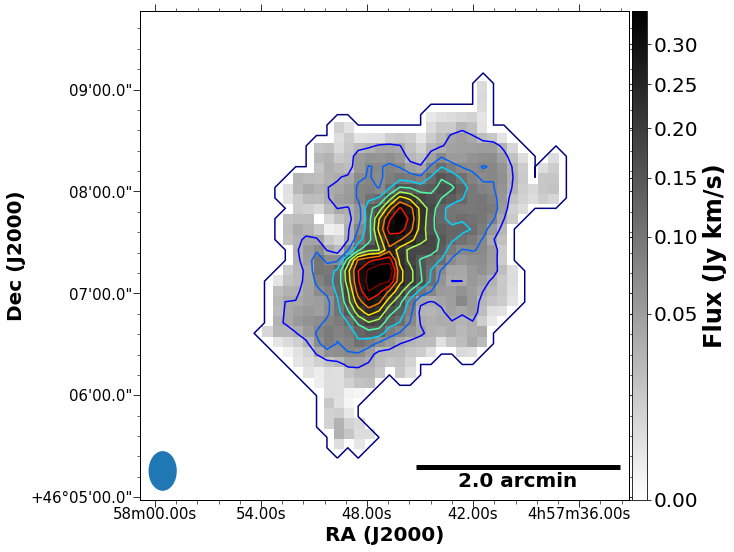

In [171]:
fig = aplpy.FITSFigure('Test.fits')
fig.show_colorscale(stretch='sqrt',interpolation='none')
#fig.add_beam()
l = 2*u.arcmin
fig.add_colorbar()
fig.colorbar.set_font(size=20)
fig.colorbar.set_axis_label_text('Flux (Jy km/s)')
fig.colorbar.set_axis_label_font(size=24, weight='bold')
fig.set_axis_labels_font(size=20, weight='bold')
fig.add_scalebar(length=l)
fig.scalebar.show(l)
fig.scalebar.set_label(l)
fig.set_tick_labels_size(size=15)
fig.scalebar.set(linestyle='solid', color='k',size=20,linewidth=5,weight='bold')
fig.set_theme('publication')
fig.show_contour(levels=10)
fig.add_beam()
fig.beam.set_corner('bottom left')
#fig.beam.set_major(23. * u.arcsec)
#fig.beam.set_minor(16. * u.arcsec)
#fig.savefig('Presentation/mom01.pdf')
plt.show()
